# Facial Keypoint Detection


## Initialize Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Convolution2D, BatchNormalization, Flatten
from tensorflow.keras.layers import Dense, Dropout, Input, MaxPool2D
from tensorflow.keras.optimizers import Nadam
from keras import backend
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import cv2
import os, gc, json, math

Using TensorFlow backend.
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.2.4
1.13.1


## Functions

In [3]:
def convert_pixels(data):
    """
    Convert pixels to the right intensity 0-1 and in a square matrix.
    """
    data = np.array([row.split(' ') for row in data['Image']],dtype='float') / 255.0
    data = data.reshape(-1,96,96,1)
    return(data)

In [4]:
def view_img(sample_img,coord=None):
    """
    Display an image. For debugging, display a coordinate on the image.
    input:
        - sample_img: numpy array. image to be displayed
        - coord: lst. of coordinates in form [[x_coordinate,y_coordinate],[x_coordinate,y_coordinate]]
    TODO handle multiple coordinates. Work out bugs with multiple coordinates
    """
    plt.figure()
    plt.imshow(sample_img.reshape(96,96),cmap='gray')
    if coord is not None:
        plt.scatter(coord[0],coord[1],marker = '*',c='r')
    plt.show()

In [5]:
def get_facial_keypoints(data,ind):
    """
    Structure the coordinates for all facial keypoints for a single image.
    inputs:
        - data: numpy array containing rows as each image sample and columns as facial keypoint coordinates
        - ind: index of the image
    output:
        - numpy array with format [[list of x-coordinates],[list of y-coordinates]]
    """
    data[ind]
    it = iter(data[ind])
    x_coord = []
    y_coord = []

    for x in it:
        x_coord.append(x)
        y_coord.append(next(it))
    
    return(np.array([x_coord,y_coord]))


## Import Data

In [6]:
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
reset_keras()    

0


In [7]:
if not os.path.exists('../output/'):
    os.makedirs('../output/model')
    os.makedirs('../output/history')
    
    
model_dir = "../output/model/"
history_dir = "../output/history/"

train_file = '../input/training/training.csv'
test_file = '../input/test/test.csv'
train_data = pd.read_csv(train_file)  
#test_data = pd.read_csv(test_file)


bad_samples = [1747, 1731, 1877, 1881, 1979, 2199, 2289, 2321, 2453, 3173, 3296, 3447, 4180, 6859,
              2090, 2175, 1907, 2562, 2818, 3296, 3447, 4263, 4482, 4490, 4636, 5059, 6493, 6585, 6906]

train_data = train_data.drop(bad_samples).reset_index(drop=True)
train_clean = train_data.dropna()


Create training vector with images and normalize thee

In [8]:
x_train = convert_pixels(train_data)
x_clean = convert_pixels(train_clean)
y_train = train_data[[col for col in train_data.columns if col != 'Image']].to_numpy()
y_clean = train_clean[[col for col in train_clean.columns if col != 'Image']].to_numpy()

Generate labels 

In [9]:

#imputer = KNNImputer(n_neighbors=3, weights='distance')

imputer = IterativeImputer(max_iter=1000, tol=0.01, random_state=42)
y_train = imputer.fit_transform(y_train)



bad_bottom_lip = [210, 350, 499, 512, 810, 839, 895, 1058, 1194,1230, 1245, 1546, 1548]

def adjust_mouth_coord(y_train):
    

    for sample in bad_bottom_lip:
        y_train[sample][29] = 94
        y_train[sample][28] = y_train[sample][26]
          
    
    
    for sample in range(len(y_train)):
        if(y_train[sample][29] < y_train[sample][27]+1):
             y_train[sample][27] = y_train[sample][29] -1
   
        if((y_train[sample][23] + y_train[sample][25]) > (2*y_train[sample][29]-1)):
             diff = y_train[sample][23] - y_train[sample][25]
       
             if(diff > 0):
                y_train[sample][23] = y_train[sample][29] -1
                y_train[sample][25] = y_train[sample][29] -1 - diff
           
             else:
                y_train[sample][23] = y_train[sample][29] -1 + diff
                y_train[sample][25] = y_train[sample][29] -1 
                
    return(y_train)           

y_train = adjust_mouth_coord(y_train)    
 
    
   

## Feature Engineering

### Set feature engineering parameters

In [10]:
fill_na = False
add_flip_horiz = True
add_blur_img = False
add_rotate_img = True
add_contrast_img = True
add_translate_img = False
orig_x_train = x_train.copy()
orig_y_train = y_train.copy()


### Fill NA in the training labels.

In [11]:
if fill_na:
    # https://stackoverflow.com/questions/18689235/numpy-array-replace-nan-values-with-average-of-columns
    # get column means
    col_mean = np.nanmean(y_train,axis=0)

    # find the x,y indices that are missing from y_train
    inds = np.where(np.isnan(y_train))

    # fill in missing values in y_train with the column means. "take" is much more efficient than fancy indexing
    y_train[inds] = np.take(col_mean, inds[1])


### Flip images horizontally and add to the training data

In [12]:
def flip_img_horiz(train_data):
    """
    Flip images horizontally for all training images
    """
    # Flip images
    x_train = convert_pixels(train_data)
    flip_img = np.array([np.fliplr(x_train[[ind]][0]) for ind in range(x_train.shape[0])])
    
    # Flip coordinates
    train_data_flip = train_data.copy()
    x_columns = [col for col in train_data.columns if '_x' in col]
    train_data_flip[x_columns] = train_data[x_columns].applymap(lambda x: 96-x)
    
    #left and right are swapped so undo
    left_columns = [col for col in train_data.columns if 'left' in col]
    right_columns = [col for col in train_data.columns if 'right' in col]
    train_data_flip[left_columns+right_columns] = train_data_flip[right_columns+left_columns]
    
    flip_coord = train_data_flip[[col for col in train_data if col != 'Image']].to_numpy()
    return(flip_img,flip_coord)

if add_flip_horiz:
    # Apply the augmentation and add the new data to the training set
    flipped_img,flipped_coord = flip_img_horiz(train_data)
    
    imputer = IterativeImputer(max_iter=1000, tol=0.01, random_state=3)
    flipped_coord = imputer.fit_transform(flipped_coord)
    flipped_coord = adjust_mouth_coord(flipped_coord)
    x_train = np.append(x_train,flipped_img,axis=0)
    y_train = np.append(y_train,flipped_coord,axis=0)
    
    
    

### Add Gaussian blurring with a 5x5 filter with $\sigma$ = 2.

In [13]:
def blur_img():
    """
    Add Gaussian blurring to the images
    """
    # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html
    blur_img = np.array([cv2.GaussianBlur(orig_x_train[[ind]][0],(5,5),2).reshape(96,96,1) for ind in range(orig_x_train.shape[0])])
    
    return(blur_img)

if add_blur_img:
    x_train = np.append(x_train,blur_img(),axis=0)
    y_train = np.append(y_train,orig_y_train,axis=0)

### Add image rotation

In [14]:
def rotate_img(x_train, y_train):
    """"
    Rotate images by angles between [5, 10, 14 degrees]
    """
    angles = [5, -5, 10, -10, 14, -14]
    b = np.ones((1,3))
    rows,cols = (96,96)
    x_train_rot = []
    y_train_rot = y_train.copy()
    M_angles = [cv2.getRotationMatrix2D((cols/2,rows/2),angle,1) for angle in angles]
    
    for i in range(x_train.shape[0]):
        #M = cv2.getRotationMatrix2D((cols/2,rows/2),np.random.choice(angles,1),1)
        M = M_angles[np.random.choice(len(M_angles))]
        x_train_rot.append((cv2.warpAffine(x_train[[i]].reshape(rows,cols,1),M,(cols,rows)).reshape(96,96,1)))
       
        #apply affine transformation to (x,y) labels
        for j in range(int(y_train.shape[1]/2)):
            b[:,0:2] = y_train[i,2*j:2*j+2]
            y_train_rot[i,2*j:2*j+2] = np.dot(b,M.transpose()) 
    
    x_train_rot = np.array(x_train_rot)
    return x_train_rot, y_train_rot

if add_rotate_img:
    
    x_rotate, y_rotate = rotate_img(orig_x_train,orig_y_train)
    x_train = np.append(x_train,x_rotate,axis=0)
    y_train = np.append(y_train,y_rotate,axis=0)   
    

### Add image contrast

In [15]:
def contrast_img(apply_random,brightness=.5):
    """
    Add brighter and darker images to the training set with the range of pixel values allowed set at 0 and 1
    Only applies contrast to the original images. Need to make sure we're not setting random seed
    input:
        - brightness: float between -1 and 1
        - apply_random: boolean. Applies random brightness to every sample in the data set.
          Ignores brightness setting
    """
    if apply_random:
        # uses a .1 increment [-.3,.8) to pick out a brightness number for each sample
        # numbers are chosen such that they are still realistically visible and
        # the added training data has an appreciable change in contrast
        brightness = np.random.choice(np.round(np.arange(-.3,.8,.1),2),size=orig_x_train.shape[0])
        bright_img = np.array([orig_x_train[[ind]][0]+brightness[ind] for ind in range(orig_x_train.shape[0])])
    else:
        bright_img = orig_x_train + brightness

    bright_img[bright_img > 1] = 1
    bright_img[bright_img < 0] = 0
    return(bright_img)
    
if add_contrast_img:
    # create two sets of images undergoing contrast changes
    x_train = np.append(x_train,contrast_img(apply_random=True),axis=0)
    y_train = np.append(y_train,orig_y_train,axis=0)
    
# testing code
# view_img(contrast_img(apply_random=True)[[30]])
# view_img(contrast_img(apply_random=True)[[30]])
# view_img(contrast_img(apply_random=True)[[30]])


In [16]:
def translate_img():
    """
    Add translational shift to the images randomly
    """
    trans_train_data = train_data.copy()
    
    rows,cols = (96,96)
    shift_x = 96*np.random.choice(np.arange(-.4,.4,.05),size=trans_train_data.shape[0])
    shift_y = 96*np.random.choice(np.arange(-.4,.4,.05),size=trans_train_data.shape[0])
    M = [np.float32([[1,0,shift_x[ind]],[0,1,shift_y[ind]]]) for ind in range(trans_train_data.shape[0])]
    trans_img = np.array([cv2.warpAffine(x_train[[ind]].reshape(96,96,1),M[ind],(cols,rows)).reshape(96,96,1) for ind in range(trans_train_data.shape[0])])
    
    x_col = [col for col in train_data.columns if ((col != 'Image') & ('_x' in col))]
    y_col = [col for col in train_data.columns if ((col != 'Image') & ('_y' in col))]

    shift_x_array = np.array([np.repeat(x,len(x_col))for x in shift_x])
    shift_y_array = np.array([np.repeat(y,len(y_col))for y in shift_y])
    
    trans_train_data[x_col] += shift_x_array
    trans_train_data[y_col] += shift_y_array
    
    trans_coord = np.array(trans_train_data[[col for col in trans_train_data.columns if col != 'Image']])

    # TODO should we force these to be nan or leave as is? If leave as is, comment this out.
    trans_coord[trans_coord > 96]= np.nan
    trans_coord[trans_coord < 0]= np.nan
    return(trans_img,trans_coord)

if add_translate_img:
    trans_img,trans_coord = translate_img()
    x_train = np.append(x_train,trans_img,axis=0)
    y_train = np.append(y_train,trans_coord,axis=0)


## Modeling

In [17]:
# Define callback function if detailed log required
class History(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.train_rmse = []
        self.val_rmse = []
        self.val_loss = []

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.train_rmse.append(logs.get('rmse'))
        
    def on_epoch_end(self, batch, logs={}):    
        self.val_rmse.append(logs.get('val_rmse'))
        self.val_loss.append(logs.get('val_loss'))
        
# Implement ModelCheckPoint callback function to save CNN model
class CNN_ModelCheckpoint(tensorflow.keras.callbacks.Callback):

    def __init__(self, model, filename):
        self.filename = filename
        self.cnn_model = model

    def on_train_begin(self, logs={}):
        self.max_val_rmse = math.inf
        
 
    def on_epoch_end(self, batch, logs={}):    
        val_rmse = logs.get('val_rmse')
        if(val_rmse < self.max_val_rmse):
           self.max_val_rmse = val_rmse
           self.cnn_model.save_weights(self.filename)


In [18]:
def final_model():
    model_input = Input(shape=(96,96,1))

    x = Convolution2D(32, (3,3), padding='same', use_bias=False)(model_input)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(32, (3,3), padding='same', use_bias=False)(model_input)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)
    x = Convolution2D(64, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(64, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)
    x = Convolution2D(96, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(96, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)
    x = Convolution2D(128, (3,3),padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(128, (3,3),padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)
    x = Convolution2D(256, (3,3),padding='same',use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(256, (3,3),padding='same',use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)
    x = Convolution2D(512, (3,3), padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha = 0.1)(x)
    x = BatchNormalization()(x)
    x = Convolution2D(512, (3,3), activation='relu', padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.1)(x)
    model_output = Dense(30)(x)
    model = Model(model_input, model_output, name="final_model")
    return model

model = final_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)    

In [19]:
# Custom RMSE metric
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

#from tensorflow.keras.optimizers.schedules import InverseTimeDecay

# Use Nadam optimizer with variable learning rate
optimizer = Nadam(lr=0.00001,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)


# Loss: MSE and Metric = RMSE
model.compile(optimizer= optimizer, 
              loss='mean_squared_error',
              metrics=[rmse])

#Callback to save the best model
saveBase_Model = CNN_ModelCheckpoint(model, model_dir+"final_model_weights.h5")

#define callback functions
callbacks = [#EarlyStopping(monitor='val_rmse', patience=3, verbose=2),
             saveBase_Model]

Instructions for updating:
Use tf.cast instead.


Run for 1000 epochs and keeping 20% train-valid split

Train on 22470 samples, validate on 5618 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1500
22470/22470 [==============================] - 26s 1ms/sample - loss: 1980.7975 - rmse: 44.1421 - val_loss: 2643.4386 - val_rmse: 51.3827
Epoch 2/1500
22470/22470 [==============================] - 18s 801us/sample - loss: 738.7576 - rmse: 26.7694 - val_loss: 2256.1264 - val_rmse: 47.4646
Epoch 3/1500
22470/22470 [==============================] - 18s 799us/sample - loss: 241.2655 - rmse: 15.1525 - val_loss: 1614.1735 - val_rmse: 40.1313
Epoch 4/1500
22470/22470 [==============================] - 18s 805us/sample - loss: 85.0213 - rmse: 8.9339 - val_loss: 1065.2654 - val_rmse: 32.5416
Epoch 5/1500
22470/22470 [==============================] - 18s 808us/sample - loss: 51.0304 - rmse: 6.9339 - val_loss: 648.0624 - val_rmse: 25.2301
Epoch 6/1500
22470/22470 [==============================] - 18s 811us/sample - loss: 45.6771 - rmse: 6.5666 - val_loss: 321.6663 - val_rmse: 17.5983


22470/22470 [==============================] - 17s 768us/sample - loss: 17.1731 - rmse: 4.0244 - val_loss: 7.0215 - val_rmse: 2.2760
Epoch 55/1500
22470/22470 [==============================] - 17s 757us/sample - loss: 16.8454 - rmse: 3.9834 - val_loss: 7.1382 - val_rmse: 2.3051
Epoch 56/1500
22470/22470 [==============================] - 17s 761us/sample - loss: 16.5211 - rmse: 3.9486 - val_loss: 6.7788 - val_rmse: 2.2358
Epoch 57/1500
22470/22470 [==============================] - 17s 757us/sample - loss: 16.3512 - rmse: 3.9267 - val_loss: 6.7984 - val_rmse: 2.2565
Epoch 58/1500
22470/22470 [==============================] - 17s 755us/sample - loss: 16.0284 - rmse: 3.8891 - val_loss: 6.7353 - val_rmse: 2.2388
Epoch 59/1500
22470/22470 [==============================] - 17s 759us/sample - loss: 15.7799 - rmse: 3.8600 - val_loss: 6.6204 - val_rmse: 2.2200
Epoch 60/1500
22470/22470 [==============================] - 17s 761us/sample - loss: 15.5185 - rmse: 3.8282 - val_loss: 6.5552 - va

Epoch 110/1500
22470/22470 [==============================] - 17s 754us/sample - loss: 8.0845 - rmse: 2.7667 - val_loss: 4.3754 - val_rmse: 1.8290
Epoch 111/1500
22470/22470 [==============================] - 17s 750us/sample - loss: 7.9742 - rmse: 2.7492 - val_loss: 4.4799 - val_rmse: 1.8634
Epoch 112/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 7.9085 - rmse: 2.7370 - val_loss: 4.4723 - val_rmse: 1.8534
Epoch 113/1500
22470/22470 [==============================] - 17s 751us/sample - loss: 7.8547 - rmse: 2.7274 - val_loss: 4.2999 - val_rmse: 1.8125
Epoch 114/1500
22470/22470 [==============================] - 17s 749us/sample - loss: 7.7624 - rmse: 2.7107 - val_loss: 4.4131 - val_rmse: 1.8387
Epoch 115/1500
22470/22470 [==============================] - 17s 747us/sample - loss: 7.6703 - rmse: 2.6962 - val_loss: 4.4158 - val_rmse: 1.8388
Epoch 116/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 7.5574 - rmse: 2.6747 - val_los

Epoch 166/1500
22470/22470 [==============================] - 17s 751us/sample - loss: 5.3415 - rmse: 2.2386 - val_loss: 3.7279 - val_rmse: 1.6785
Epoch 167/1500
22470/22470 [==============================] - 17s 749us/sample - loss: 5.3059 - rmse: 2.2321 - val_loss: 3.8494 - val_rmse: 1.7049
Epoch 168/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 5.2903 - rmse: 2.2274 - val_loss: 3.8285 - val_rmse: 1.6974
Epoch 169/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 5.2709 - rmse: 2.2241 - val_loss: 3.8160 - val_rmse: 1.6987
Epoch 170/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 5.2488 - rmse: 2.2185 - val_loss: 3.9467 - val_rmse: 1.7229
Epoch 171/1500
22470/22470 [==============================] - 17s 750us/sample - loss: 5.2259 - rmse: 2.2112 - val_loss: 3.7426 - val_rmse: 1.6826
Epoch 172/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 5.1766 - rmse: 2.2026 - val_los

Epoch 222/1500
22470/22470 [==============================] - 17s 747us/sample - loss: 4.2205 - rmse: 1.9795 - val_loss: 3.5261 - val_rmse: 1.6279
Epoch 223/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 4.2265 - rmse: 1.9800 - val_loss: 3.3833 - val_rmse: 1.5888
Epoch 224/1500
22470/22470 [==============================] - 17s 750us/sample - loss: 4.1771 - rmse: 1.9704 - val_loss: 3.5599 - val_rmse: 1.6350
Epoch 225/1500
22470/22470 [==============================] - 17s 751us/sample - loss: 4.1874 - rmse: 1.9704 - val_loss: 3.3410 - val_rmse: 1.5805
Epoch 226/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 4.1728 - rmse: 1.9680 - val_loss: 3.4170 - val_rmse: 1.5997
Epoch 227/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 4.1326 - rmse: 1.9579 - val_loss: 3.4310 - val_rmse: 1.6004
Epoch 228/1500
22470/22470 [==============================] - 17s 750us/sample - loss: 4.1373 - rmse: 1.9582 - val_los

Epoch 278/1500
22470/22470 [==============================] - 17s 752us/sample - loss: 3.5792 - rmse: 1.8157 - val_loss: 3.2387 - val_rmse: 1.5405
Epoch 279/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 3.5782 - rmse: 1.8144 - val_loss: 3.1974 - val_rmse: 1.5345
Epoch 280/1500
22470/22470 [==============================] - 17s 753us/sample - loss: 3.5423 - rmse: 1.8061 - val_loss: 3.1140 - val_rmse: 1.5140
Epoch 281/1500
22470/22470 [==============================] - 17s 751us/sample - loss: 3.5571 - rmse: 1.8082 - val_loss: 3.2371 - val_rmse: 1.5354
Epoch 282/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 3.5644 - rmse: 1.8106 - val_loss: 3.1382 - val_rmse: 1.5147
Epoch 283/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 3.5312 - rmse: 1.8029 - val_loss: 3.2438 - val_rmse: 1.5411
Epoch 284/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 3.5280 - rmse: 1.8005 - val_los

Epoch 334/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 3.1581 - rmse: 1.6990 - val_loss: 3.0957 - val_rmse: 1.5017
Epoch 335/1500
22470/22470 [==============================] - 17s 749us/sample - loss: 3.1611 - rmse: 1.7000 - val_loss: 3.0096 - val_rmse: 1.4689
Epoch 336/1500
22470/22470 [==============================] - 17s 747us/sample - loss: 3.1451 - rmse: 1.6955 - val_loss: 2.9750 - val_rmse: 1.4607
Epoch 337/1500
22470/22470 [==============================] - 17s 749us/sample - loss: 3.1396 - rmse: 1.6934 - val_loss: 3.0193 - val_rmse: 1.4749
Epoch 338/1500
22470/22470 [==============================] - 17s 756us/sample - loss: 3.1348 - rmse: 1.6920 - val_loss: 2.9373 - val_rmse: 1.4504
Epoch 339/1500
22470/22470 [==============================] - 17s 750us/sample - loss: 3.1530 - rmse: 1.6955 - val_loss: 3.0344 - val_rmse: 1.4747
Epoch 340/1500
22470/22470 [==============================] - 17s 749us/sample - loss: 3.1095 - rmse: 1.6848 - val_los

Epoch 390/1500
22470/22470 [==============================] - 17s 747us/sample - loss: 2.8714 - rmse: 1.6133 - val_loss: 2.8997 - val_rmse: 1.4288
Epoch 391/1500
22470/22470 [==============================] - 17s 752us/sample - loss: 2.8740 - rmse: 1.6151 - val_loss: 2.8085 - val_rmse: 1.4094
Epoch 392/1500
22470/22470 [==============================] - 17s 756us/sample - loss: 2.8617 - rmse: 1.6121 - val_loss: 2.8751 - val_rmse: 1.4208
Epoch 393/1500
22470/22470 [==============================] - 17s 747us/sample - loss: 2.8378 - rmse: 1.6043 - val_loss: 2.9037 - val_rmse: 1.4402
Epoch 394/1500
22470/22470 [==============================] - 17s 747us/sample - loss: 2.8271 - rmse: 1.6021 - val_loss: 2.9155 - val_rmse: 1.4379
Epoch 395/1500
22470/22470 [==============================] - 17s 747us/sample - loss: 2.8336 - rmse: 1.6038 - val_loss: 2.8544 - val_rmse: 1.4189
Epoch 396/1500
22470/22470 [==============================] - 17s 750us/sample - loss: 2.8217 - rmse: 1.6004 - val_los

Epoch 446/1500
22470/22470 [==============================] - 17s 749us/sample - loss: 2.6388 - rmse: 1.5423 - val_loss: 2.7864 - val_rmse: 1.3845
Epoch 447/1500
22470/22470 [==============================] - 17s 750us/sample - loss: 2.6340 - rmse: 1.5420 - val_loss: 2.7217 - val_rmse: 1.3695
Epoch 448/1500
22470/22470 [==============================] - 18s 821us/sample - loss: 2.6233 - rmse: 1.5387 - val_loss: 2.7609 - val_rmse: 1.3821
Epoch 449/1500
22470/22470 [==============================] - 18s 789us/sample - loss: 2.6150 - rmse: 1.5373 - val_loss: 2.7238 - val_rmse: 1.3779
Epoch 450/1500
22470/22470 [==============================] - 18s 780us/sample - loss: 2.6149 - rmse: 1.5357 - val_loss: 2.7947 - val_rmse: 1.3879
Epoch 451/1500
22470/22470 [==============================] - 18s 779us/sample - loss: 2.6239 - rmse: 1.5384 - val_loss: 2.8714 - val_rmse: 1.4075
Epoch 452/1500
22470/22470 [==============================] - 18s 782us/sample - loss: 2.6018 - rmse: 1.5327 - val_los

Epoch 502/1500
22470/22470 [==============================] - 17s 747us/sample - loss: 2.4554 - rmse: 1.4846 - val_loss: 2.7306 - val_rmse: 1.3604
Epoch 503/1500
22470/22470 [==============================] - 17s 747us/sample - loss: 2.4600 - rmse: 1.4840 - val_loss: 2.7068 - val_rmse: 1.3646
Epoch 504/1500
22470/22470 [==============================] - 17s 751us/sample - loss: 2.4662 - rmse: 1.4860 - val_loss: 2.7106 - val_rmse: 1.3498
Epoch 505/1500
22470/22470 [==============================] - 17s 747us/sample - loss: 2.4327 - rmse: 1.4784 - val_loss: 2.6617 - val_rmse: 1.3411
Epoch 506/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 2.4159 - rmse: 1.4739 - val_loss: 2.7598 - val_rmse: 1.3663
Epoch 507/1500
22470/22470 [==============================] - 17s 749us/sample - loss: 2.4464 - rmse: 1.4807 - val_loss: 2.7641 - val_rmse: 1.3645
Epoch 508/1500
22470/22470 [==============================] - 17s 747us/sample - loss: 2.4081 - rmse: 1.4712 - val_los

Epoch 558/1500
22470/22470 [==============================] - 17s 747us/sample - loss: 2.3211 - rmse: 1.4412 - val_loss: 2.5534 - val_rmse: 1.3055
Epoch 559/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 2.3075 - rmse: 1.4366 - val_loss: 2.5729 - val_rmse: 1.3125
Epoch 560/1500
22470/22470 [==============================] - 17s 752us/sample - loss: 2.3213 - rmse: 1.4408 - val_loss: 2.4937 - val_rmse: 1.2966
Epoch 561/1500
22470/22470 [==============================] - 17s 749us/sample - loss: 2.2941 - rmse: 1.4328 - val_loss: 2.5436 - val_rmse: 1.3101
Epoch 562/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 2.2690 - rmse: 1.4254 - val_loss: 2.5283 - val_rmse: 1.3028
Epoch 563/1500
22470/22470 [==============================] - 17s 747us/sample - loss: 2.2950 - rmse: 1.4327 - val_loss: 2.6930 - val_rmse: 1.3572
Epoch 564/1500
22470/22470 [==============================] - 17s 750us/sample - loss: 2.2814 - rmse: 1.4276 - val_los

Epoch 614/1500
22470/22470 [==============================] - 17s 749us/sample - loss: 2.1959 - rmse: 1.3979 - val_loss: 2.5262 - val_rmse: 1.2985
Epoch 615/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 2.1841 - rmse: 1.3947 - val_loss: 2.5728 - val_rmse: 1.3049
Epoch 616/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 2.1929 - rmse: 1.3959 - val_loss: 2.5308 - val_rmse: 1.2883
Epoch 617/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 2.1816 - rmse: 1.3931 - val_loss: 2.4921 - val_rmse: 1.2772
Epoch 618/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 2.1671 - rmse: 1.3885 - val_loss: 2.4929 - val_rmse: 1.2805
Epoch 619/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 2.1636 - rmse: 1.3881 - val_loss: 2.4692 - val_rmse: 1.2752
Epoch 620/1500
22470/22470 [==============================] - 17s 749us/sample - loss: 2.1821 - rmse: 1.3934 - val_los

Epoch 670/1500
22470/22470 [==============================] - 17s 750us/sample - loss: 2.0751 - rmse: 1.3566 - val_loss: 2.4748 - val_rmse: 1.2669
Epoch 671/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 2.0650 - rmse: 1.3548 - val_loss: 2.4310 - val_rmse: 1.2551
Epoch 672/1500
22470/22470 [==============================] - 17s 750us/sample - loss: 2.0854 - rmse: 1.3578 - val_loss: 2.4204 - val_rmse: 1.2534
Epoch 673/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 2.0680 - rmse: 1.3540 - val_loss: 2.3989 - val_rmse: 1.2497
Epoch 674/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 2.0650 - rmse: 1.3539 - val_loss: 2.4365 - val_rmse: 1.2602
Epoch 675/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 2.0593 - rmse: 1.3511 - val_loss: 2.3635 - val_rmse: 1.2465
Epoch 676/1500
22470/22470 [==============================] - 17s 749us/sample - loss: 2.0529 - rmse: 1.3493 - val_los

Epoch 726/1500
22470/22470 [==============================] - 17s 752us/sample - loss: 1.9915 - rmse: 1.3267 - val_loss: 2.4493 - val_rmse: 1.2570
Epoch 727/1500
22470/22470 [==============================] - 17s 749us/sample - loss: 1.9935 - rmse: 1.3260 - val_loss: 2.4688 - val_rmse: 1.2535
Epoch 728/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 1.9985 - rmse: 1.3287 - val_loss: 2.3390 - val_rmse: 1.2288
Epoch 729/1500
22470/22470 [==============================] - 17s 746us/sample - loss: 1.9676 - rmse: 1.3187 - val_loss: 2.3321 - val_rmse: 1.2251
Epoch 730/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 1.9843 - rmse: 1.3248 - val_loss: 2.4946 - val_rmse: 1.2581
Epoch 731/1500
22470/22470 [==============================] - 17s 749us/sample - loss: 1.9881 - rmse: 1.3242 - val_loss: 2.4151 - val_rmse: 1.2402
Epoch 732/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 1.9753 - rmse: 1.3215 - val_los

Epoch 782/1500
22470/22470 [==============================] - 17s 764us/sample - loss: 1.9113 - rmse: 1.2987 - val_loss: 2.3092 - val_rmse: 1.2058
Epoch 783/1500
22470/22470 [==============================] - 17s 759us/sample - loss: 1.9075 - rmse: 1.2960 - val_loss: 2.4257 - val_rmse: 1.2353
Epoch 784/1500
22470/22470 [==============================] - 17s 759us/sample - loss: 1.9236 - rmse: 1.3011 - val_loss: 2.3991 - val_rmse: 1.2329
Epoch 785/1500
22470/22470 [==============================] - 17s 758us/sample - loss: 1.9177 - rmse: 1.2998 - val_loss: 2.3278 - val_rmse: 1.2091
Epoch 786/1500
22470/22470 [==============================] - 17s 758us/sample - loss: 1.9091 - rmse: 1.2950 - val_loss: 2.4369 - val_rmse: 1.2339
Epoch 787/1500
22470/22470 [==============================] - 17s 756us/sample - loss: 1.9187 - rmse: 1.2999 - val_loss: 2.4313 - val_rmse: 1.2385
Epoch 788/1500
22470/22470 [==============================] - 17s 758us/sample - loss: 1.9098 - rmse: 1.2965 - val_los

Epoch 838/1500
22470/22470 [==============================] - 17s 765us/sample - loss: 1.8568 - rmse: 1.2761 - val_loss: 2.2737 - val_rmse: 1.1920
Epoch 839/1500
22470/22470 [==============================] - 17s 759us/sample - loss: 1.8756 - rmse: 1.2827 - val_loss: 2.4117 - val_rmse: 1.2443
Epoch 840/1500
22470/22470 [==============================] - 17s 762us/sample - loss: 1.8539 - rmse: 1.2757 - val_loss: 2.2109 - val_rmse: 1.1746
Epoch 841/1500
22470/22470 [==============================] - 17s 759us/sample - loss: 1.8600 - rmse: 1.2773 - val_loss: 2.3495 - val_rmse: 1.2111
Epoch 842/1500
22470/22470 [==============================] - 17s 764us/sample - loss: 1.8528 - rmse: 1.2758 - val_loss: 2.4114 - val_rmse: 1.2290
Epoch 843/1500
22470/22470 [==============================] - 17s 770us/sample - loss: 1.8644 - rmse: 1.2774 - val_loss: 2.3182 - val_rmse: 1.2059
Epoch 844/1500
22470/22470 [==============================] - 18s 794us/sample - loss: 1.8404 - rmse: 1.2716 - val_los

Epoch 894/1500
22470/22470 [==============================] - 17s 747us/sample - loss: 1.8115 - rmse: 1.2594 - val_loss: 2.2556 - val_rmse: 1.1825
Epoch 895/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 1.7855 - rmse: 1.2508 - val_loss: 2.3567 - val_rmse: 1.1969
Epoch 896/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 1.7737 - rmse: 1.2471 - val_loss: 2.3291 - val_rmse: 1.1957
Epoch 897/1500
22470/22470 [==============================] - 17s 747us/sample - loss: 1.7935 - rmse: 1.2528 - val_loss: 2.2918 - val_rmse: 1.1881
Epoch 898/1500
22470/22470 [==============================] - 17s 749us/sample - loss: 1.7890 - rmse: 1.2516 - val_loss: 2.4002 - val_rmse: 1.2057
Epoch 899/1500
22470/22470 [==============================] - 17s 748us/sample - loss: 1.8008 - rmse: 1.2549 - val_loss: 2.2604 - val_rmse: 1.1893
Epoch 900/1500
22470/22470 [==============================] - 17s 751us/sample - loss: 1.7884 - rmse: 1.2515 - val_los

Epoch 950/1500
22470/22470 [==============================] - 16s 716us/sample - loss: 1.7389 - rmse: 1.2334 - val_loss: 2.2313 - val_rmse: 1.1701
Epoch 951/1500
22470/22470 [==============================] - 16s 713us/sample - loss: 1.7515 - rmse: 1.2345 - val_loss: 2.3407 - val_rmse: 1.1929
Epoch 952/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.7478 - rmse: 1.2347 - val_loss: 2.1965 - val_rmse: 1.1646
Epoch 953/1500
22470/22470 [==============================] - 16s 713us/sample - loss: 1.7609 - rmse: 1.2397 - val_loss: 2.2128 - val_rmse: 1.1686
Epoch 954/1500
22470/22470 [==============================] - 16s 713us/sample - loss: 1.7467 - rmse: 1.2355 - val_loss: 2.2796 - val_rmse: 1.1742
Epoch 955/1500
22470/22470 [==============================] - 16s 712us/sample - loss: 1.7433 - rmse: 1.2342 - val_loss: 2.2713 - val_rmse: 1.1746
Epoch 956/1500
22470/22470 [==============================] - 16s 713us/sample - loss: 1.7297 - rmse: 1.2298 - val_los

Epoch 1006/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.7140 - rmse: 1.2210 - val_loss: 2.3164 - val_rmse: 1.1837
Epoch 1007/1500
22470/22470 [==============================] - 16s 713us/sample - loss: 1.7084 - rmse: 1.2203 - val_loss: 2.1908 - val_rmse: 1.1659
Epoch 1008/1500
22470/22470 [==============================] - 16s 717us/sample - loss: 1.6944 - rmse: 1.2158 - val_loss: 2.2566 - val_rmse: 1.1616
Epoch 1009/1500
22470/22470 [==============================] - 16s 712us/sample - loss: 1.6997 - rmse: 1.2170 - val_loss: 2.1931 - val_rmse: 1.1529
Epoch 1010/1500
22470/22470 [==============================] - 16s 721us/sample - loss: 1.7067 - rmse: 1.2186 - val_loss: 2.1681 - val_rmse: 1.1490
Epoch 1011/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.7205 - rmse: 1.2228 - val_loss: 2.1876 - val_rmse: 1.1556
Epoch 1012/1500
22470/22470 [==============================] - 16s 715us/sample - loss: 1.7158 - rmse: 1.2214 - 

22470/22470 [==============================] - 16s 713us/sample - loss: 1.6656 - rmse: 1.2039 - val_loss: 2.2114 - val_rmse: 1.1528
Epoch 1062/1500
22470/22470 [==============================] - 16s 716us/sample - loss: 1.6596 - rmse: 1.2020 - val_loss: 2.2666 - val_rmse: 1.1681
Epoch 1063/1500
22470/22470 [==============================] - 16s 718us/sample - loss: 1.6616 - rmse: 1.2022 - val_loss: 2.1012 - val_rmse: 1.1246
Epoch 1064/1500
22470/22470 [==============================] - 16s 716us/sample - loss: 1.6642 - rmse: 1.2033 - val_loss: 2.2979 - val_rmse: 1.1708
Epoch 1065/1500
22470/22470 [==============================] - 16s 715us/sample - loss: 1.6762 - rmse: 1.2067 - val_loss: 2.2764 - val_rmse: 1.1636
Epoch 1066/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.6536 - rmse: 1.2007 - val_loss: 2.1908 - val_rmse: 1.1436
Epoch 1067/1500
22470/22470 [==============================] - 16s 715us/sample - loss: 1.6508 - rmse: 1.1989 - val_loss: 2.1767

22470/22470 [==============================] - 16s 725us/sample - loss: 1.6443 - rmse: 1.1941 - val_loss: 2.2376 - val_rmse: 1.1516
Epoch 1117/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.6378 - rmse: 1.1935 - val_loss: 2.2105 - val_rmse: 1.1509
Epoch 1118/1500
22470/22470 [==============================] - 16s 712us/sample - loss: 1.6380 - rmse: 1.1931 - val_loss: 2.2468 - val_rmse: 1.1609
Epoch 1119/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.6370 - rmse: 1.1908 - val_loss: 2.1910 - val_rmse: 1.1434
Epoch 1120/1500
22470/22470 [==============================] - 16s 715us/sample - loss: 1.6345 - rmse: 1.1899 - val_loss: 2.2096 - val_rmse: 1.1508
Epoch 1121/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.6194 - rmse: 1.1853 - val_loss: 2.2306 - val_rmse: 1.1583
Epoch 1122/1500
22470/22470 [==============================] - 16s 717us/sample - loss: 1.6330 - rmse: 1.1890 - val_loss: 2.2589

22470/22470 [==============================] - 16s 714us/sample - loss: 1.5878 - rmse: 1.1730 - val_loss: 2.4622 - val_rmse: 1.2070
Epoch 1172/1500
22470/22470 [==============================] - 16s 716us/sample - loss: 1.6079 - rmse: 1.1790 - val_loss: 2.1252 - val_rmse: 1.1248
Epoch 1173/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.6107 - rmse: 1.1804 - val_loss: 2.3737 - val_rmse: 1.1816
Epoch 1174/1500
22470/22470 [==============================] - 16s 713us/sample - loss: 1.5944 - rmse: 1.1759 - val_loss: 2.1817 - val_rmse: 1.1298
Epoch 1175/1500
22470/22470 [==============================] - 16s 715us/sample - loss: 1.5979 - rmse: 1.1760 - val_loss: 2.1361 - val_rmse: 1.1233
Epoch 1176/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.6074 - rmse: 1.1784 - val_loss: 2.2494 - val_rmse: 1.1556
Epoch 1177/1500
22470/22470 [==============================] - 16s 717us/sample - loss: 1.5901 - rmse: 1.1728 - val_loss: 2.2459

22470/22470 [==============================] - 16s 715us/sample - loss: 1.5757 - rmse: 1.1658 - val_loss: 2.1063 - val_rmse: 1.1214
Epoch 1227/1500
22470/22470 [==============================] - 16s 716us/sample - loss: 1.5691 - rmse: 1.1641 - val_loss: 2.1286 - val_rmse: 1.1193
Epoch 1228/1500
22470/22470 [==============================] - 16s 713us/sample - loss: 1.5702 - rmse: 1.1661 - val_loss: 2.1028 - val_rmse: 1.1105
Epoch 1229/1500
22470/22470 [==============================] - 16s 715us/sample - loss: 1.5856 - rmse: 1.1692 - val_loss: 2.1293 - val_rmse: 1.1191
Epoch 1230/1500
22470/22470 [==============================] - 16s 715us/sample - loss: 1.5732 - rmse: 1.1666 - val_loss: 2.1369 - val_rmse: 1.1195
Epoch 1231/1500
22470/22470 [==============================] - 16s 713us/sample - loss: 1.5924 - rmse: 1.1715 - val_loss: 2.2134 - val_rmse: 1.1388
Epoch 1232/1500
22470/22470 [==============================] - 16s 715us/sample - loss: 1.5664 - rmse: 1.1631 - val_loss: 2.2911

22470/22470 [==============================] - 16s 717us/sample - loss: 1.5651 - rmse: 1.1615 - val_loss: 2.1259 - val_rmse: 1.1157
Epoch 1282/1500
22470/22470 [==============================] - 16s 717us/sample - loss: 1.5345 - rmse: 1.1506 - val_loss: 2.2029 - val_rmse: 1.1264
Epoch 1283/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.5446 - rmse: 1.1543 - val_loss: 2.1166 - val_rmse: 1.1078
Epoch 1284/1500
22470/22470 [==============================] - 16s 717us/sample - loss: 1.5429 - rmse: 1.1535 - val_loss: 2.2093 - val_rmse: 1.1309
Epoch 1285/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.5499 - rmse: 1.1579 - val_loss: 2.1155 - val_rmse: 1.1140
Epoch 1286/1500
22470/22470 [==============================] - 16s 715us/sample - loss: 1.5563 - rmse: 1.1575 - val_loss: 2.2797 - val_rmse: 1.1463
Epoch 1287/1500
22470/22470 [==============================] - 16s 715us/sample - loss: 1.5470 - rmse: 1.1564 - val_loss: 2.1764

22470/22470 [==============================] - 16s 720us/sample - loss: 1.5339 - rmse: 1.1488 - val_loss: 2.0624 - val_rmse: 1.0988
Epoch 1337/1500
22470/22470 [==============================] - 16s 713us/sample - loss: 1.5101 - rmse: 1.1415 - val_loss: 2.2678 - val_rmse: 1.1425
Epoch 1338/1500
22470/22470 [==============================] - 16s 715us/sample - loss: 1.5081 - rmse: 1.1412 - val_loss: 2.0761 - val_rmse: 1.0988
Epoch 1339/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.5363 - rmse: 1.1487 - val_loss: 2.1357 - val_rmse: 1.1280
Epoch 1340/1500
22470/22470 [==============================] - 16s 726us/sample - loss: 1.5378 - rmse: 1.1479 - val_loss: 2.1919 - val_rmse: 1.1252
Epoch 1341/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.5201 - rmse: 1.1454 - val_loss: 2.2335 - val_rmse: 1.1366
Epoch 1342/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.5131 - rmse: 1.1426 - val_loss: 2.1604

22470/22470 [==============================] - 16s 714us/sample - loss: 1.5048 - rmse: 1.1359 - val_loss: 2.2158 - val_rmse: 1.1228
Epoch 1392/1500
22470/22470 [==============================] - 16s 718us/sample - loss: 1.4995 - rmse: 1.1375 - val_loss: 2.1147 - val_rmse: 1.1003
Epoch 1393/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.4940 - rmse: 1.1341 - val_loss: 2.0787 - val_rmse: 1.1020
Epoch 1394/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.5140 - rmse: 1.1413 - val_loss: 2.1905 - val_rmse: 1.1200
Epoch 1395/1500
22470/22470 [==============================] - 16s 712us/sample - loss: 1.5029 - rmse: 1.1377 - val_loss: 2.1829 - val_rmse: 1.1178
Epoch 1396/1500
22470/22470 [==============================] - 16s 716us/sample - loss: 1.5000 - rmse: 1.1357 - val_loss: 2.3501 - val_rmse: 1.1618
Epoch 1397/1500
22470/22470 [==============================] - 16s 713us/sample - loss: 1.5046 - rmse: 1.1366 - val_loss: 2.1681

22470/22470 [==============================] - 16s 715us/sample - loss: 1.4849 - rmse: 1.1305 - val_loss: 2.2950 - val_rmse: 1.1411
Epoch 1447/1500
22470/22470 [==============================] - 16s 713us/sample - loss: 1.4864 - rmse: 1.1289 - val_loss: 2.2579 - val_rmse: 1.1426
Epoch 1448/1500
22470/22470 [==============================] - 16s 715us/sample - loss: 1.4905 - rmse: 1.1312 - val_loss: 2.0650 - val_rmse: 1.0978
Epoch 1449/1500
22470/22470 [==============================] - 16s 715us/sample - loss: 1.4844 - rmse: 1.1304 - val_loss: 2.1858 - val_rmse: 1.1138
Epoch 1450/1500
22470/22470 [==============================] - 16s 714us/sample - loss: 1.4942 - rmse: 1.1309 - val_loss: 2.1815 - val_rmse: 1.1166
Epoch 1451/1500
22470/22470 [==============================] - 16s 713us/sample - loss: 1.4746 - rmse: 1.1254 - val_loss: 2.3096 - val_rmse: 1.1450
Epoch 1452/1500
22470/22470 [==============================] - 16s 718us/sample - loss: 1.4862 - rmse: 1.1296 - val_loss: 2.0647

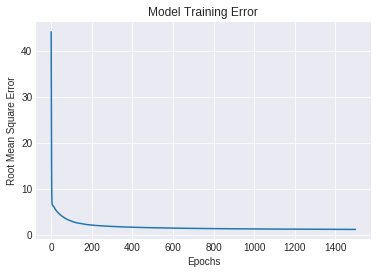

In [20]:

USE_SAVED_MODEL = False

if USE_SAVED_MODEL == False:
    history = model.fit(x_train,
                    y_train,
                    epochs = 1500,
                    batch_size = 256,
                    validation_split = 0.2, #data = (x_test, y_test),
                    callbacks = callbacks
                    )
    plt.style.use('seaborn-darkgrid')
    plt.plot(history.history['rmse'])
    
     #save history as JSON file
    with open(history_dir +'history.json', 'w') as f:
        json.dump(str(history.history), f)
    plt.xlabel('Epochs')
    plt.ylabel('Root Mean Square Error')
    plt.title('Model Training Error')
    plt.show() 
    
else:
    model.load_weights(model_dir+"final_model_weights.h5")
                    

In [21]:
lookid_dir = '../input/IdLookupTable.csv'
lookid_data = pd.read_csv(lookid_dir)
test_data = pd.read_csv(test_file)

x_test = []
for i in range(0,len(test_data)):
    img = test_data['Image'][i].split(' ')
    x_test.append(img)
    
x_test = np.array(x_test,dtype = 'float')
x_test = x_test/255.0
x_test = x_test.reshape(-1,96,96,1)    

y_test = model.predict(x_test)
y_test = np.clip(y_test,0,96)

lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pred_list = list(y_test)

rowid = list(lookid_data['RowId'])

feature = []
for f in list(lookid_data['FeatureName']):
    feature.append(lookid_list.index(f))
    
    
submit_data = []
for x,y in zip(imageID,feature):
    submit_data.append(pred_list[x][y])
rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(submit_data,name = 'Location')
submission = pd.concat([rowid,loc],axis = 1)
submission.to_csv('../output/w207_temp_submission.csv',index = False)   


In [ ]:
if 1:
    sess = get_session()
    clear_session()
    sess.close()
 
    try:
        del model # this is from global space - change this as you need
    except:
        print("Model clear Failed")
    print(gc.collect())    